In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata
import dataload as epi
import scib_metrics
from scib_metrics.benchmark import Benchmarker
import scvi
import importlib
import epipack as epk

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be remov

### epipack

In [7]:
genescore_mtx = sc.read_h5ad("../../data/mouse_atlas/genescore_cc_cx_final.h5ad")
peak_1 = sc.read_h5ad("../../data/mouse_atlas/cortex_cc/peak_cc.h5ad")
peak_2 = sc.read_h5ad("../../data/mouse_atlas/cortex_cx/peak_cx.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")

In [3]:
batch_id = [0 for _ in range(peak_1.shape[0])] + [1 for _ in range(peak_2.shape[0])]

In [19]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_rec=1, reg_z_l2=0.1, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [20]:
epi_integration.train_model(nepochs=200, rec_loss='MSE')

Epochs: 100%|██████████| 200/200 [03:17<00:00,  1.02it/s, val_kl_loss=1.62e+6, val_loss_z_dist=0.498, val_mmd=0.00258, val_rec_loss=2.05]


In [21]:
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_5'] = z.detach().cpu().numpy()

In [5]:
## no z reg
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=1, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [6]:
epi_integration.train_model(nepochs=200, rec_loss='MSE')

Epochs:   0%|          | 0/200 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.75 GiB (GPU 0; 44.35 GiB total capacity; 1.04 GiB already allocated; 2.73 GiB free; 1.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [36]:
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd__1'] = z.detach().cpu().numpy()

In [ ]:
## parameter test

In [108]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=2, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)

epi_integration.train_model(nepochs=200, rec_loss='MSE')

z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd_2_z_0_01_rep1'] = z.detach().cpu().numpy()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s, val_kl_loss=1.84e+6, val_loss_z_dist=0.809, val_mmd=0.00219, val_rec_loss=2.1] 


In [109]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=2, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)
epi_integration.train_model(nepochs=200, rec_loss='MSE')
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd_2_z_0_01_rep2'] = z.detach().cpu().numpy()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs:   4%|▍         | 8/200 [00:07<03:05,  1.04it/s, val_kl_loss=5.66e+5, val_loss_z_dist=2.4, val_mmd=0.00432, val_rec_loss=2.76] 

Epochs: 100%|██████████| 200/200 [03:16<00:00,  1.02it/s, val_kl_loss=1.87e+6, val_loss_z_dist=1.05, val_mmd=0.00225, val_rec_loss=2.11]


In [110]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=2, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)
epi_integration.train_model(nepochs=200, rec_loss='MSE')
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd_2_z_0_01_rep3'] = z.detach().cpu().numpy()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epochs: 100%|██████████| 200/200 [03:27<00:00,  1.04s/it, val_kl_loss=1.88e+6, val_loss_z_dist=1.02, val_mmd=0.0022, val_rec_loss=2.11] 


In [111]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=2, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)
epi_integration.train_model(nepochs=200, rec_loss='MSE')
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd_2_z_0_01_rep4'] = z.detach().cpu().numpy()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epochs: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s, val_kl_loss=1.83e+6, val_loss_z_dist=0.751, val_mmd=0.00226, val_rec_loss=2.1] 


In [112]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=genescore_mtx.layers['count'], enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-10, reg_mmd=2, reg_rec=1, reg_z_l2=0.01, use_batch_norm=True, use_layer_norm=False)
epi_integration.train_model(nepochs=200, rec_loss='MSE')
z = epi_integration.get_latent()
genescore_mtx.obsm['epipack_mmd_2_z_0_01_rep5'] = z.detach().cpu().numpy()

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


Epochs:   6%|▌         | 12/200 [00:10<02:49,  1.11it/s, val_kl_loss=5.54e+5, val_loss_z_dist=1.94, val_mmd=0.00378, val_rec_loss=2.63]

Epochs: 100%|██████████| 200/200 [03:10<00:00,  1.05it/s, val_kl_loss=1.91e+6, val_loss_z_dist=1.12, val_mmd=0.00224, val_rec_loss=2.11]


In [67]:
genescore_mtx

AnnData object with n_obs × n_vars = 12445 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap', 'pca'
    obsm: 'Combat', 'PeakVI', 'X_umap', 'epipack', 'harmony', 'seurat', 'trVAE', 'epipack_mmd_1_z_0_01_rep1', 'epipack_mmd_1_z_0_01_rep2', 'epipack_mmd_1_z_0_01_rep3', 'epipack_mmd_1_z_0_01_rep4', 'epipack_mmd_1_z_0_01_rep5', 'epipack_mmd_1_z_0_05_rep1', 'epipack_mmd_1_z_0_05_rep2', 'epipack_mmd_1_z_0_05_rep3', 'epipack_mmd_1_z_0_05_rep4', 'epipack_mmd_1_z_0_05_rep5', 'epipack_mmd_1_z_0_5_rep1', 'epipack_mmd_1_z_0_5_rep2', 'epipack_mmd_1_z_0_5_rep3', 'epipack_mmd_1_z_0_5_rep4', 'epipack_mmd_1_z_0_5_rep5', 'epipack_mmd_1_z_1_rep1', 'epipack_mmd_1_z_1_rep2', 'epipack_mmd_1_z_1_rep3', 'epipack_mmd_1_z_1_rep4', 'epipack_mmd_1_z_1_rep5', 'epipack_mmd_1_z_0_1_re

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


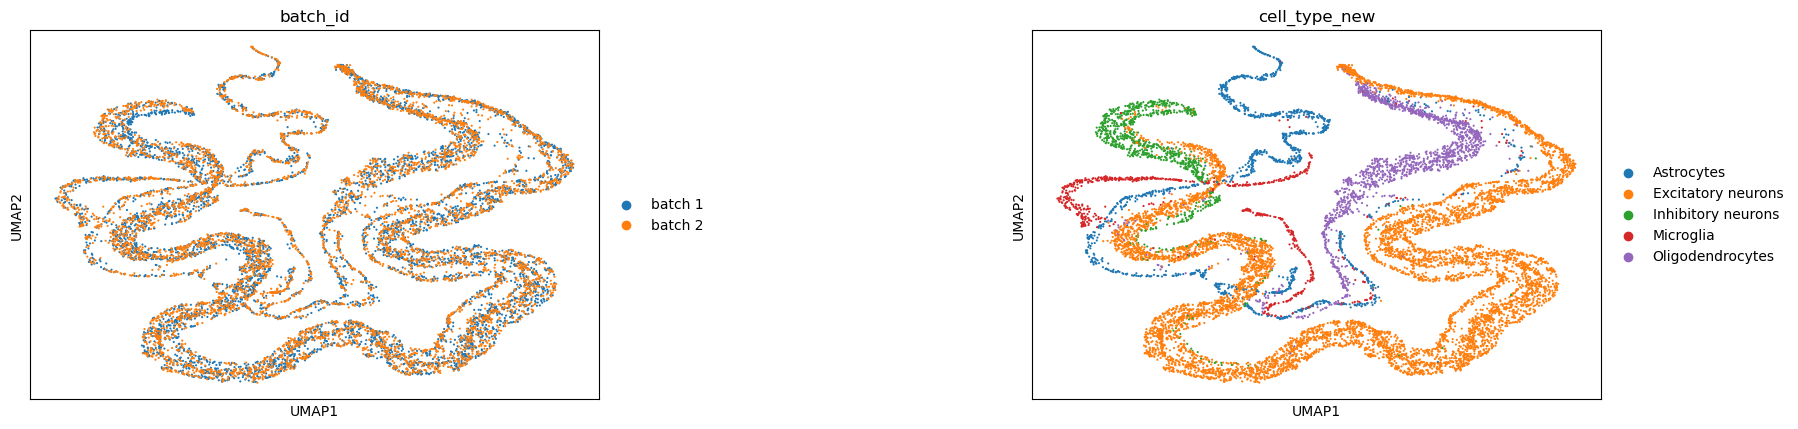

In [75]:
sc.pp.neighbors(genescore_mtx, n_neighbors=10, use_rep='epipack_w/o_zreg')
sc.tl.umap(genescore_mtx)
#sc.tl.leiden(genescore_mtx, resolution=0.5)
sc.pl.umap(genescore_mtx, color=['batch_id','cell_type_new'], ncols=2, wspace=0.6)

### peakvi

In [38]:
merge_peak.obs['dataset'] = merge.obs['dataset']
peakvi_test = merge_peak

In [39]:
min_cells = int(peakvi_test.shape[0] * 0.05)
sc.pp.filter_genes(peakvi_test, min_cells=min_cells)

In [40]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 142/500:  28%|██▊       | 142/500 [11:50<29:50,  5.00s/it, v_num=1, train_loss_step=7.3e+7, train_loss_epoch=2.72e+8] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 16875.938. Signaling Trainer to stop.


In [41]:
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_1"] = latent

In [44]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_2"] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 143/500:  29%|██▊       | 143/500 [10:59<27:26,  4.61s/it, v_num=1, train_loss_step=7.41e+7, train_loss_epoch=2.71e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 17281.002. Signaling Trainer to stop.


In [45]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_3"] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 143/500:  29%|██▊       | 143/500 [11:00<27:29,  4.62s/it, v_num=1, train_loss_step=6.8e+7, train_loss_epoch=2.72e+8] 
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 17237.494. Signaling Trainer to stop.


In [46]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_4"] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 135/500:  27%|██▋       | 135/500 [10:27<28:15,  4.65s/it, v_num=1, train_loss_step=6.76e+7, train_loss_epoch=2.72e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 17230.676. Signaling Trainer to stop.


In [47]:
scvi.model.PEAKVI.setup_anndata(peakvi_test, batch_key="dataset")
pvi = scvi.model.PEAKVI(peakvi_test)
pvi.train()
latent = pvi.get_latent_representation()
genescore_mtx.obsm["PeakVI_5"] = latent

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Epoch 131/500:  26%|██▌       | 131/500 [10:25<29:21,  4.77s/it, v_num=1, train_loss_step=6.93e+7, train_loss_epoch=2.72e+8]
Monitored metric reconstruction_loss_validation did not improve in the last 50 records. Best score: 17102.174. Signaling Trainer to stop.


In [49]:
genescore_mtx

AnnData object with n_obs × n_vars = 12445 × 3000
    obs: 'celltype', 'batch_id', 'leiden'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_umap', 'epipack', 'epipack_1', 'epipack_2', 'epipack_3', 'epipack_4', 'epipack_5', 'epipack_w/o_zreg_5', 'epipack_w/o_zreg_4', 'epipack_w/o_zreg_3', 'epipack_w/o_zreg_2', 'epipack_w/o_zreg_1', 'PeakVI_1', 'PeakVI_2', 'PeakVI_3', 'PeakVI_4', 'PeakVI_5'
    layers: 'count'
    obsp: 'connectivities', 'distances'

### Combat

In [48]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

In [50]:
peak_combat = merge_peak
#sc.pp.combat(peak_combat, key='dataset')

In [51]:
min_cells = int(peak_combat.shape[0] * 0.3)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

In [52]:
sc.pp.combat(peak_combat, key='dataset')
sc.pp.log1p(peak_combat)
sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

In [53]:
genescore_mtx.obsm['Combat_1'] = peak_combat.obsm['X_pca']

In [54]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

peak_combat = merge_peak
min_cells = int(peak_combat.shape[0] * 0.3)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

sc.pp.combat(peak_combat, key='dataset')
sc.pp.log1p(peak_combat)
sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

genescore_mtx.obsm['Combat_2'] = peak_combat.obsm['X_pca']

In [55]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

peak_combat = merge_peak
min_cells = int(peak_combat.shape[0] * 0.3)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

sc.pp.combat(peak_combat, key='dataset')
sc.pp.log1p(peak_combat)
sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

genescore_mtx.obsm['Combat_3'] = peak_combat.obsm['X_pca']

In [56]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

peak_combat = merge_peak
min_cells = int(peak_combat.shape[0] * 0.3)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

sc.pp.combat(peak_combat, key='dataset')
sc.pp.log1p(peak_combat)
sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

genescore_mtx.obsm['Combat_4'] = peak_combat.obsm['X_pca']

In [57]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

peak_combat = merge_peak
min_cells = int(peak_combat.shape[0] * 0.3)
sc.pp.filter_genes(peak_combat, min_cells=min_cells)

sc.pp.combat(peak_combat, key='dataset')
sc.pp.log1p(peak_combat)
sc.pp.scale(peak_combat, max_value=10)
sc.tl.pca(peak_combat, svd_solver='arpack')

genescore_mtx.obsm['Combat_5'] = peak_combat.obsm['X_pca']

### harmony & seurat

In [63]:
harmony = pd.read_csv("../../data/mouse_atlas/merge_cc_cx/harmony_peak_repeat5.csv", index_col=0)
merge_peak.obsm['harmony_5'] = harmony

In [68]:
seurat = pd.read_csv("../../data/mouse_atlas/merge_cc_cx/seuratcca_peak_repeat5.csv", index_col=0)
merge_peak.obsm['seurat_5'] = seurat

In [69]:
name_list = []
for i in merge_peak.obs_names:
    i = i.split('_')
    name = i[0]
    name_list.append(name)

In [70]:
merge_peak.obs_names = name_list

In [71]:
genescore_mtx.obsm['seurat_1'] = merge_peak.obsm['seurat_1']
genescore_mtx.obsm['seurat_2'] = merge_peak.obsm['seurat_2']
genescore_mtx.obsm['seurat_3'] = merge_peak.obsm['seurat_3']
genescore_mtx.obsm['seurat_4'] = merge_peak.obsm['seurat_4']
genescore_mtx.obsm['seurat_5'] = merge_peak.obsm['seurat_5']
genescore_mtx.obsm['harmony_1'] = merge_peak.obsm['harmony_1']
genescore_mtx.obsm['harmony_2'] = merge_peak.obsm['harmony_2']
genescore_mtx.obsm['harmony_3'] = merge_peak.obsm['harmony_3']
genescore_mtx.obsm['harmony_4'] = merge_peak.obsm['harmony_4']
genescore_mtx.obsm['harmony_5'] = merge_peak.obsm['harmony_5']

### trVAE

In [72]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

merge_peak.X = merge_peak.raw.X

In [73]:
min_cells = int(merge_peak.shape[0] * 0.1)
sc.pp.filter_genes(merge_peak, min_cells=min_cells)

In [95]:
epi_integration = epk.ml.BridgeVAE(promoter_dt=merge_peak.X.todense(), enhancer_z = np.concatenate((peak_1.obsm['epipack_z_bce'], peak_2.obsm['epipack_z_bce']), axis=0),
                         batch_id=batch_id, 
                         z_dim=50, batch_size=512, layer_num=2, reg_kl=1e-6, reg_mmd=0.01, reg_rec=1, reg_z_l2=0, use_batch_norm=True, use_layer_norm=False)

- Model initializing...
- [Auto-detection]: GPU detetced. Model will be initialized in GPU mode.
- Initialization complete...


In [96]:
epi_integration.train_model(nepochs=100, rec_loss='MSE')

Epochs: 100%|██████████| 100/100 [03:10<00:00,  1.90s/it, val_kl_loss=2.59e+5, val_loss_z_dist=1.63, val_mmd=0.00442, val_rec_loss=1.1]


In [97]:
z = epi_integration.get_latent()
genescore_mtx.obsm['trVAE_5'] = z.detach().cpu().numpy()

### liger

In [2]:
import pyliger

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [3]:
merge_peak = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge_peak.h5ad")
merge = sc.read_h5ad("../../data/mouse_atlas/merge_cc_cx/merge.h5ad")
merge_peak.obs['dataset'] = merge.obs['dataset']

merge_peak.X = merge_peak.raw.X

liger_test = merge_peak

In [4]:
min_cells = int(liger_test.shape[0] * 0.2)
sc.pp.filter_genes(liger_test, min_cells=min_cells)

In [5]:
batch_list = ['batch 1','batch 2']

In [6]:
bdata = merge_peak.copy()
adata_list = [bdata[bdata.obs.dataset == b].copy() for b in batch_list]

In [7]:
for i, ad in enumerate(adata_list):
    ad.uns["sample_name"] = batch_list[i]
    # Hack to make sure each method uses the same genes
    ad.uns["var_gene_idx"] = np.arange(bdata.n_vars)

In [8]:
liger_data = pyliger.create_liger(adata_list, remove_missing=False, make_sparse=False)
# Hack to make sure each method uses the same genes
liger_data.var_genes = bdata.var_names
pyliger.normalize(liger_data)
pyliger.scale_not_center(liger_data)
pyliger.optimize_ALS(liger_data, k=30)
pyliger.quantile_norm(liger_data)

genescore_mtx.obsm["LIGER_5"] = np.zeros((genescore_mtx.shape[0], liger_data.adata_list[0].obsm["H_norm"].shape[1]))
for i, b in enumerate(batch_list):
    genescore_mtx.obsm["LIGER_5"][genescore_mtx.obs.batch_id == b] = liger_data.adata_list[i].obsm["H_norm"]

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/pyliger/preprocessing/_scale.py:88: RuntimeWarning: divide by zero encountered in divide
  3%|▎         | 1/30 [00:05<02:27,  5.09s/it]


KeyboardInterrupt: 

In [11]:
adata_list[1].X

<6218x8768 sparse matrix of type '<class 'numpy.float64'>'
	with 17431096 stored elements in Compressed Sparse Row format>

### benchmarking

In [115]:
biocon = scib_metrics.benchmark.BioConservation(isolated_labels=False, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=False)
batchcor = scib_metrics.benchmark.BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=False, pcr_comparison=False)

In [97]:
genescore_mtx

AnnData object with n_obs × n_vars = 12445 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap', 'pca'
    obsm: 'Combat', 'PeakVI', 'X_umap', 'epipack', 'harmony', 'seurat', 'trVAE', 'epipack_mmd_1_z_0_01_rep1', 'epipack_mmd_1_z_0_01_rep2', 'epipack_mmd_1_z_0_01_rep3', 'epipack_mmd_1_z_0_01_rep4', 'epipack_mmd_1_z_0_01_rep5', 'epipack_mmd_1_z_0_05_rep1', 'epipack_mmd_1_z_0_05_rep2', 'epipack_mmd_1_z_0_05_rep3', 'epipack_mmd_1_z_0_05_rep4', 'epipack_mmd_1_z_0_05_rep5', 'epipack_mmd_1_z_0_5_rep1', 'epipack_mmd_1_z_0_5_rep2', 'epipack_mmd_1_z_0_5_rep3', 'epipack_mmd_1_z_0_5_rep4', 'epipack_mmd_1_z_0_5_rep5', 'epipack_mmd_1_z_1_rep1', 'epipack_mmd_1_z_1_rep2', 'epipack_mmd_1_z_1_rep3', 'epipack_mmd_1_z_1_rep4', 'epipack_mmd_1_z_1_rep5', 'epipack_mmd_1_z_0_1_re

In [117]:
bm = Benchmarker(
    genescore_mtx,
    batch_key="batch_id",
    label_key="cell_type_new",
    embedding_obsm_keys=["epipack_1", "epipack_2", "epipack_3", "epipack_4", "epipack_5",
                          "epipack_w/o_zreg_1", "epipack_w/o_zreg_2", "epipack_w/o_zreg_3", "epipack_w/o_zreg_4", "epipack_w/o_zreg_5",
                            "harmony_1", "harmony_2", "harmony_3", "harmony_4", "harmony_5",
                            'seurat_1', 'seurat_2', 'seurat_3', 'seurat_4', 'seurat_5',
                            'PeakVI_1','PeakVI_2', 'PeakVI_3', 'PeakVI_4', 'PeakVI_5',
                            'Combat_1', 'Combat_2', 'Combat_3', 'Combat_4', 'Combat_5',
                            'trVAE_1', 'trVAE_2', 'trVAE_3', 'trVAE_4', 'trVAE_5',
                            'LIGER_1', 'LIGER_2', 'LIGER_3', 'LIGER_4', 'LIGER_5'],
    bio_conservation_metrics=biocon,
    batch_correction_metrics = batchcor,
    n_jobs=1
)

In [118]:
bm.benchmark()

Embeddings: 100%|██████████| 40/40 [13:33<00:00, 20.34s/it]


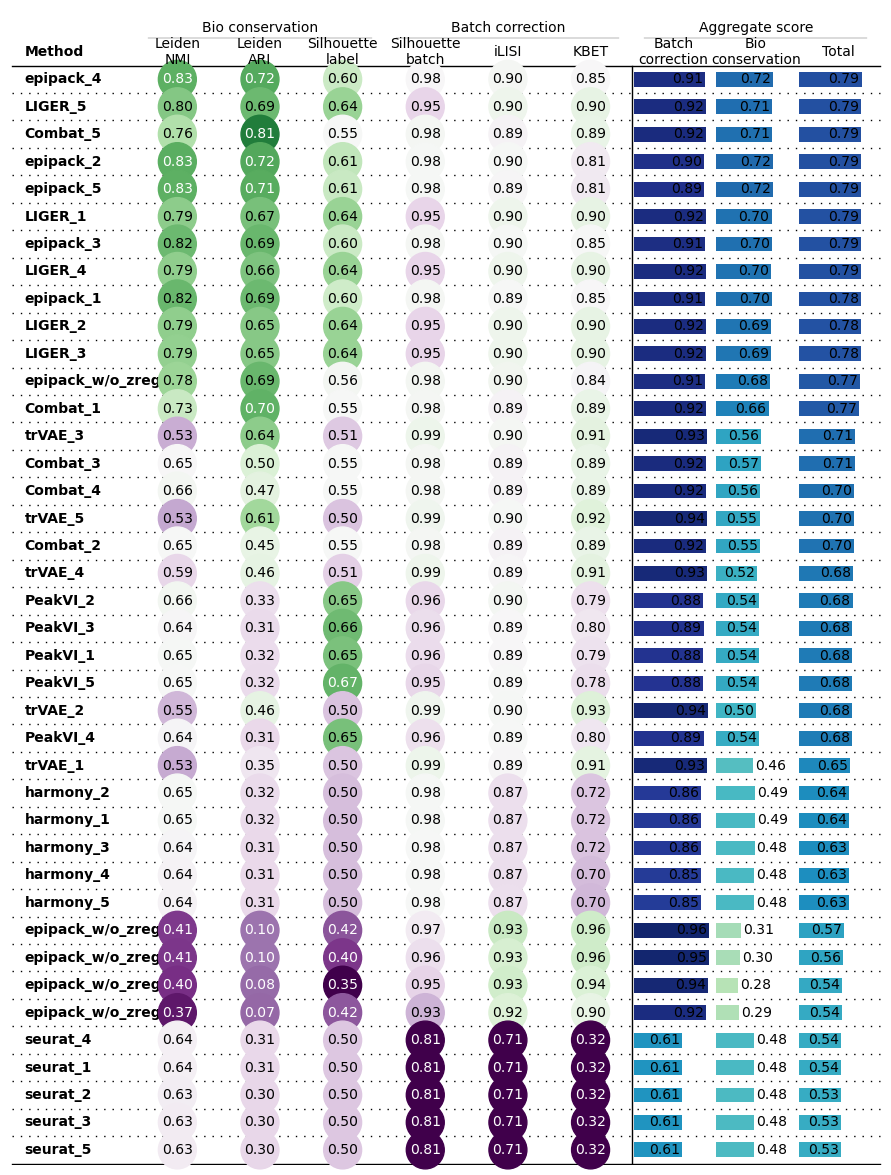

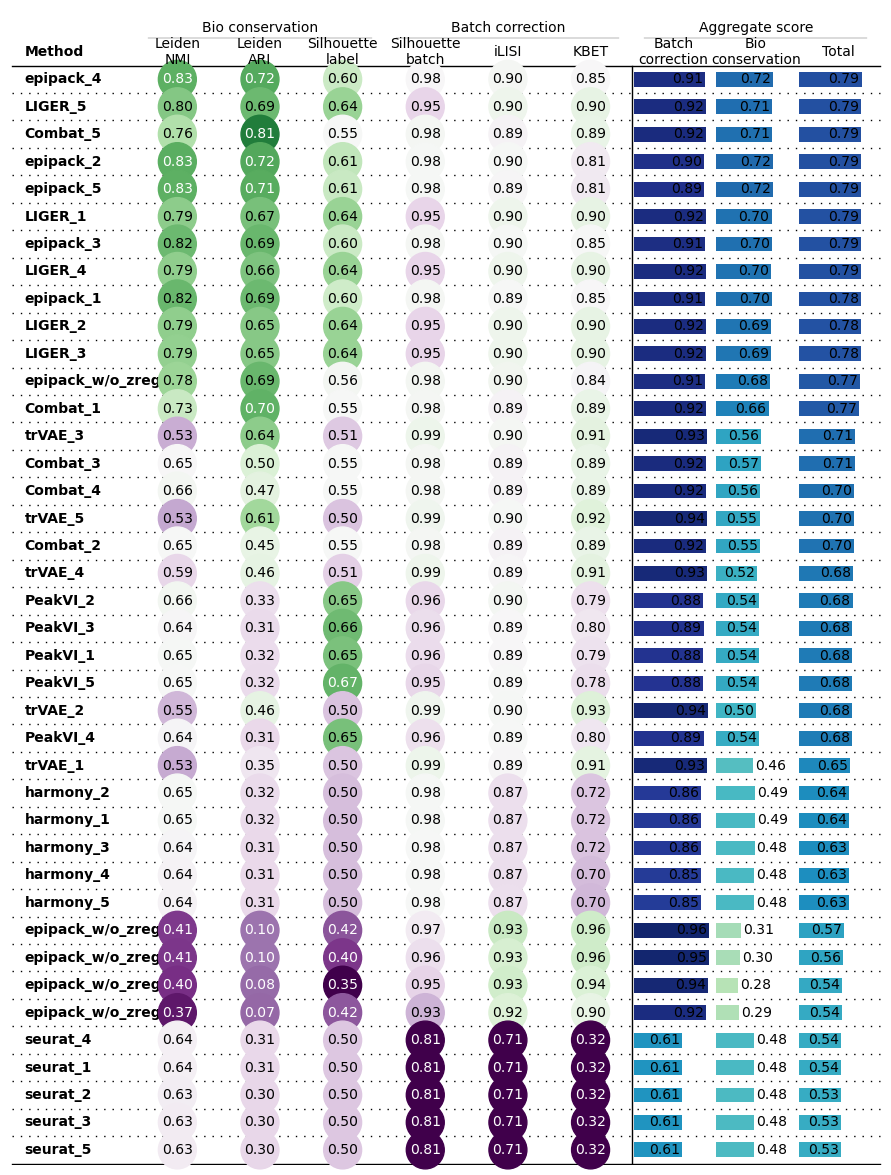

In [120]:
%matplotlib inline
bm.plot_results_table(min_max_scale=False)

In [98]:
bm.plot_results_table(min_max_scale=False)

In [121]:
df = bm.get_results(min_max_scale=False)

In [123]:
df.to_csv("../../data/mouse_atlas/result_5_repeat.csv")

In [124]:
df = pd.read_csv("../../data/mouse_atlas/result_5_repeat.csv")

In [125]:
df

,Embedding,Leiden NMI,Leiden ARI,Silhouette label,Silhouette batch,iLISI,KBET,Batch correction,Bio conservation,Total
0,epipack_1,0.8203198884752586,0.68736584227578,0.5997839719057083,0.9822918,0.8936320543289185,0.8459190780523042,0.9072809833487742,0.7024899008855824,0.7844063338708591
1,epipack_2,0.8334382944198906,0.7209063359399138,0.6115477830171585,0.98124754,0.8959866762161255,0.8121112446398133,0.8964484883815246,0.7219641377923209,0.7917578780280023
2,epipack_3,0.8181286134328397,0.6910375031206849,0.6030378192663193,0.9827412,0.8951247930526733,0.8496323383595474,0.9091661028314274,0.7040679786066146,0.7861072282965398
3,epipack_4,0.8294033811905439,0.7170196372773703,0.6032592430710793,0.9799407,0.8963141441345215,0.8476101390899323,0.9079549985587962,0.7165607538463311,0.7931184517313172
4,epipack_5,0.829083515034989,0.7145360047690822,0.6054107993841171,0.981497,0.891646146774292,0.8081394507681768,0.893760862423163,0.7163434397293962,0.787310408806903
5,epipack_w/o_zreg_1,0.7800242780304661,0.6898681119987102,0.5587733015418053,0.98358524,0.9006086587905884,0.8376005309719989,0.9072648094064378,0.6762218971903272,0.7686390620767715
6,epipack_w/o_zreg_2,0.41460548518154744,0.09504507862038172,0.4214155301451683,0.97116184,0.9343909025192261,0.9639028085411854,0.9564851844688675,0.3103553646490325,0.5688072925769666
7,epipack_w/o_zreg_3,0.40457712720544714,0.07886501061450063,0.35497812926769257,0.9516474,0.9297658205032349,0.9350144169216785,0.9388092127603104,0.2794734223625468,0.5432077385216523
8,epipack_w/o_zreg_4,0.4109799902428777,0.09635544072924115,0.4040077477693558,0.961063,0.9262887239456177,0.9634751910964952,0.9502756474746699,0.30378105958049156,0.5623788947381629
9,epipack_w/o_zreg_5,0.3720903803915475,0.07489727637518417,0.422528438270092,0.93166095,0.921518087387085,0.8966586237993202,0.9166125537900912,0.2898386983456079,0.5405482405234012


In [134]:
genescore_mtx.write_h5ad("../../data/mouse_atlas/genescore_mtx_with_5_repeat_final.h5ad")

In [150]:
genescore_mtx_final = sc.read_h5ad("../../data/mouse_atlas/genescore_cc_cx_final.h5ad")

In [146]:
genescore_mtx

AnnData object with n_obs × n_vars = 12445 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'umap', 'pca'
    obsm: 'X_umap', 'epipack', 'epipack_1', 'epipack_2', 'epipack_3', 'epipack_4', 'epipack_5', 'epipack_w/o_zreg_5', 'epipack_w/o_zreg_4', 'epipack_w/o_zreg_3', 'epipack_w/o_zreg_2', 'epipack_w/o_zreg_1', 'PeakVI_1', 'PeakVI_2', 'PeakVI_3', 'PeakVI_4', 'PeakVI_5', 'Combat_1', 'Combat_2', 'Combat_3', 'Combat_4', 'Combat_5', 'seurat_1', 'seurat_2', 'seurat_3', 'seurat_4', 'seurat_5', 'harmony_1', 'harmony_2', 'harmony_3', 'harmony_4', 'harmony_5', 'trVAE_1', 'trVAE_3', 'trVAE_2', 'trVAE_4', 'trVAE_5', 'LIGER_1', 'LIGER_2', 'LIGER_3', 'LIGER_4', 'LIGER_5', 'X_pca'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [154]:
genescore_mtx.obsm['epipack_w_o_zreg_1'] = genescore_mtx.obsm['epipack_w/o_zreg_1']
genescore_mtx.obsm['epipack_w_o_zreg_2'] = genescore_mtx.obsm['epipack_w/o_zreg_2']
genescore_mtx.obsm['epipack_w_o_zreg_3'] = genescore_mtx.obsm['epipack_w/o_zreg_3']
genescore_mtx.obsm['epipack_w_o_zreg_4'] = genescore_mtx.obsm['epipack_w/o_zreg_4']
genescore_mtx.obsm['epipack_w_o_zreg_5'] = genescore_mtx.obsm['epipack_w/o_zreg_5']

In [159]:
del genescore_mtx.obsm['epipack_w/o_zreg_5']

In [160]:
genescore_mtx.write_h5ad("../../data/mouse_atlas/genescore_mtx_with_5_repeat_final.h5ad")

In [161]:
tmp = sc.read_h5ad("../../data/mouse_atlas/genescore_mtx_with_5_repeat_final.h5ad")

In [40]:
## parameter benchmarking ##

biocon = scib_metrics.benchmark.BioConservation(isolated_labels=False, nmi_ari_cluster_labels_leiden=True, nmi_ari_cluster_labels_kmeans=False, silhouette_label=True, clisi_knn=False)
batchcor = scib_metrics.benchmark.BatchCorrection(silhouette_batch=True, ilisi_knn=True, kbet_per_label=True, graph_connectivity=False, pcr_comparison=False)

In [113]:
bm = Benchmarker(
    genescore_mtx,
    batch_key="batch_id",
    label_key="cell_type_new",
    embedding_obsm_keys=["epipack_mmd_2_z_0_01_rep1", "epipack_mmd_2_z_0_01_rep2", "epipack_mmd_2_z_0_01_rep3", "epipack_mmd_2_z_0_01_rep4", "epipack_mmd_2_z_0_01_rep5",
                          "epipack_mmd_2_z_0_05_rep1", "epipack_mmd_2_z_0_05_rep2", "epipack_mmd_2_z_0_05_rep3", "epipack_mmd_2_z_0_05_rep4", "epipack_mmd_2_z_0_05_rep5",
                            "epipack_mmd_2_z_0_1_rep1", "epipack_mmd_2_z_0_1_rep2", "epipack_mmd_2_z_0_1_rep3", "epipack_mmd_2_z_0_1_rep4", "epipack_mmd_2_z_0_1_rep5",
                            'epipack_mmd_2_z_0_5_rep1', 'epipack_mmd_2_z_0_5_rep2', 'epipack_mmd_2_z_0_5_rep3', 'epipack_mmd_2_z_0_5_rep4', 'epipack_mmd_2_z_0_5_rep5',
                            'epipack_mmd_2_z_1_rep1','epipack_mmd_2_z_1_rep2', 'epipack_mmd_2_z_1_rep3', 'epipack_mmd_2_z_1_rep4', 'epipack_mmd_2_z_1_rep5'],
    bio_conservation_metrics=biocon,
    batch_correction_metrics = batchcor,
    n_jobs=1
)

In [114]:
bm.benchmark()

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/nethome/ycheng430/miniconda3/envs/epipack/lib/p

Embeddings: 100%|██████████| 25/25 [09:25<00:00, 22.63s/it]


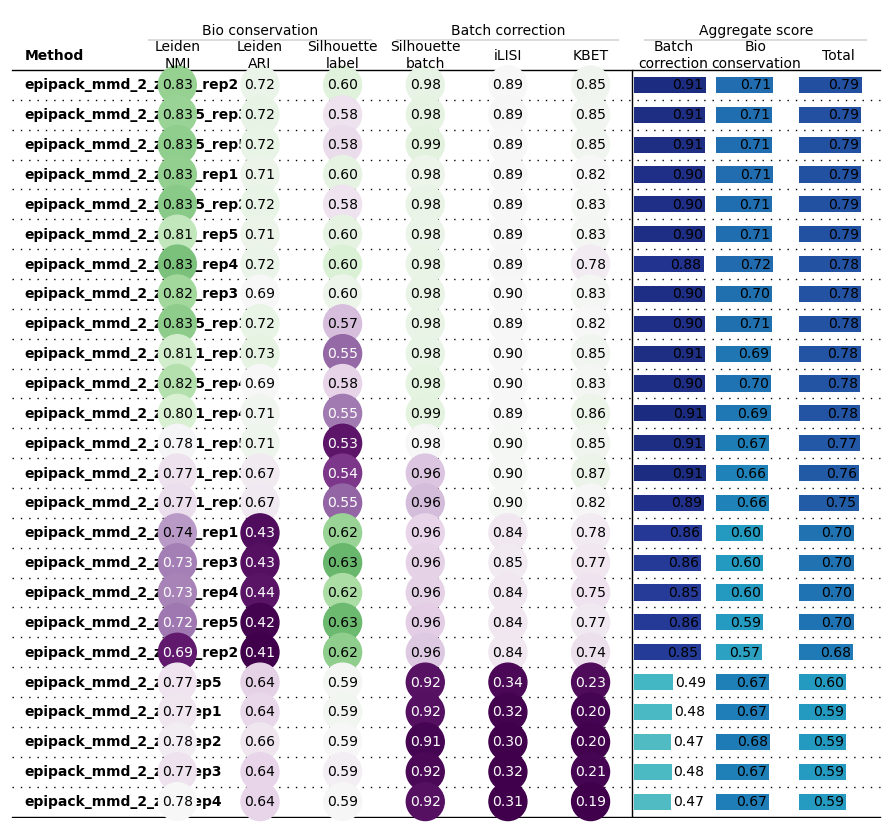

In [115]:
bm.plot_results_table(min_max_scale=False)

In [116]:
df = bm.get_results(min_max_scale=False)

In [117]:
df

,Leiden NMI,Leiden ARI,Silhouette label,Silhouette batch,iLISI,KBET,Batch correction,Bio conservation,Total
Embedding,,,,,,,,,
epipack_mmd_2_z_0_01_rep1,0.805346,0.725019,0.549271,0.983303,0.895359,0.850701,0.909788,0.693212,0.779842
epipack_mmd_2_z_0_01_rep2,0.767806,0.669325,0.548916,0.957975,0.900304,0.820007,0.892762,0.662016,0.754315
epipack_mmd_2_z_0_01_rep3,0.769911,0.672698,0.539579,0.960506,0.900772,0.870078,0.910452,0.660729,0.760619
epipack_mmd_2_z_0_01_rep4,0.801911,0.705553,0.553404,0.985343,0.894351,0.86288,0.914191,0.686956,0.77785
epipack_mmd_2_z_0_01_rep5,0.779986,0.708453,0.530814,0.977098,0.898697,0.850522,0.908772,0.673084,0.767359
epipack_mmd_2_z_0_05_rep1,0.828434,0.71977,0.571432,0.982709,0.894174,0.821535,0.899473,0.706545,0.783716
epipack_mmd_2_z_0_05_rep2,0.829474,0.719424,0.583798,0.982909,0.893579,0.827038,0.901175,0.710899,0.787009
epipack_mmd_2_z_0_05_rep3,0.825297,0.722224,0.58341,0.984536,0.892071,0.848425,0.908344,0.71031,0.789524
epipack_mmd_2_z_0_05_rep4,0.817149,0.693024,0.577996,0.984899,0.895016,0.833264,0.904393,0.696056,0.779391


In [118]:
df.to_csv("../../data/mouse_atlas/mmd_2_result_5_repeat.csv")

In [120]:
genescore_mtx.write_h5ad("../../data/mouse_atlas/parameter_test_1007.h5ad")

In [3]:
tmp = sc.read_h5ad("../../data/mouse_atlas/genescore_mtx_with_5_repeat_final.h5ad")

/nethome/ycheng430/miniconda3/envs/epipack/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
tmp

AnnData object with n_obs × n_vars = 12445 × 3000
    obs: 'celltype', 'batch_id', 'leiden', 'cell_type_new'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_id_colors', 'celltype_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap'
    obsm: 'Combat_1', 'Combat_2', 'Combat_3', 'Combat_4', 'Combat_5', 'LIGER_1', 'LIGER_2', 'LIGER_3', 'LIGER_4', 'LIGER_5', 'PeakVI_1', 'PeakVI_2', 'PeakVI_3', 'PeakVI_4', 'PeakVI_5', 'X_pca', 'X_umap', 'epipack', 'epipack_1', 'epipack_2', 'epipack_3', 'epipack_4', 'epipack_5', 'epipack_w_o_zreg_1', 'epipack_w_o_zreg_2', 'epipack_w_o_zreg_3', 'epipack_w_o_zreg_4', 'epipack_w_o_zreg_5', 'harmony_1', 'harmony_2', 'harmony_3', 'harmony_4', 'harmony_5', 'seurat_1', 'seurat_2', 'seurat_3', 'seurat_4', 'seurat_5', 'trVAE_1', 'trVAE_2', 'trVAE_3', 'trVAE_4', 'trVAE_5'
    varm: 'PCs'
    layers: 'count'
    obsp: 'connectivities', 'distances'

In [5]:
a = pd.DataFrame(tmp.obs['cell_type_new'])
a.to_csv("../../data/mouse_atlas/celltype.csv")

In [131]:
a = pd.DataFrame(tmp.obsm['PeakVI_5'])
a.to_csv("../../data/mouse_atlas/peakvi_embedding.csv")